In [1]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow import feature_column as fc
from tensorflow.keras import layers, models, Model
%matplotlib inline

from data_utils import get_column_input_dict

print(tf.version.VERSION)

2021-11-03 00:37:07.839910: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0


2.3.4


In [2]:
train_df = pd.read_csv('./data/train_energy.csv')
print(f'train shape: {train_df.shape}')
eval_df = pd.read_csv('./data/validate_energy.csv')
print(f'eval shape: {eval_df.shape}')
test_df = pd.read_csv('./data/test_energy.csv')
print(f'test shape: {test_df.shape}')

train shape: (351802, 314)
eval shape: (117268, 314)
test shape: (117268, 314)


In [3]:
col_dict = get_column_input_dict(train_df)
col_dict.keys()

dict_keys(['CSV_COLUMNS', 'LABEL_COLUMNS', 'STRING_COLS', 'NUMERIC_COLS', 'DEFAULTS', 'EXCLUSION_COLS'])

In [4]:
train_df[['day_of_year_sin_T0', 'day_of_year_cos_T0']].describe()

,day_of_year_sin_T0,day_of_year_cos_T0
count,351802.000000,351802.000000
mean,0.000398,-0.031225
std,0.717839,0.695511
min,-0.999963,-1.000000
25%,-0.733885,-0.728028
50%,0.034328,-0.042905
75%,0.722117,0.653680
max,0.999963,1.000000


### Means and Standard Deviations Defined From Training Dataset

In [5]:
def z_score(x, mean_x, std_x):
    
    return (x - mean_x) / std_x

def normalize_data(df):
    
    df = df.copy()
    
    # energy columns
    energy_mean = train_df['total_consumption_T0'].mean()
    energy_std = train_df['total_consumption_T0'].std()
    energy_cols = [col for col in train_df.columns if col.startswith('total_consumption_T_minus_')]
    
    for col in energy_cols:
        df[col] = df[col].apply(z_score, args=(energy_mean, energy_std))
        
    # min temp columns 
    min_temp_mean = train_df['min_temp_T0'].mean()
    min_temp_std = train_df['min_temp_T0'].std()
    min_temp_cols = [col for col in train_df.columns if col.startswith('min_temp_T')]
    
    for col in min_temp_cols:
        df[col] = df[col].apply(z_score, args=(min_temp_mean, min_temp_std))
        
    # max temp columns
    max_temp_mean = train_df['max_temp_T0'].mean()
    max_temp_std = train_df['max_temp_T0'].std()
    max_temp_cols = [col for col in train_df.columns if col.startswith('max_temp_T')]
    
    for col in max_temp_cols:
        df[col] = df[col].apply(z_score, args=(max_temp_mean, max_temp_std))
        
    return df

In [6]:
train_df_z_scored = normalize_data(train_df)
eval_df_z_scored = normalize_data(eval_df)
test_df_z_scored = normalize_data(test_df)

### Column Labels for First Record in DataFrame

In [7]:
train_df_z_scored[col_dict['LABEL_COLUMNS']].values[0]

array([7415.77136515, 6121.89789123, 5896.23751387, 5859.54495006,
       5859.51165372, 6977.95782464, 5682.83018868, 5734.572697  ,
       5767.20310766, 5786.35960044, 5939.54495006, 5967.48057714,
       7323.04106548, 5998.97891232, 5918.43507214, 6028.53496115,
       5790.86570477, 6565.92674806, 5506.31520533, 5590.63263041,
       5681.74250832, 5782.77469478, 6052.14206437, 6004.46170921,
       5742.91897891, 5510.72142064, 5141.30965594, 5393.09655938])

In [8]:
def df_to_dataset(dataframe, feature_columns, label_columns, shuffle=True, batch_size=32):
    
    dataframe = dataframe.copy()
    labels = dataframe[label_columns].values
    
    for col in dataframe.columns:
        if col not in feature_columns:
            dataframe.pop(col)
    
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    
    return ds

In [9]:
def create_input_layers(numeric_cols, string_cols):
    """Creates dictionary of input layers for each feature.

    Returns:
        Dictionary of `tf.Keras.layers.Input` layers for each feature.
    """
    inputs = {
        colname: tf.keras.layers.Input(
            name=colname, shape=(1), dtype="float32")
        for colname in numeric_cols}

    inputs.update({
        colname: tf.keras.layers.Input(
            name=colname, shape=(1), dtype="string")
        for colname in string_cols})

    return inputs

In [10]:
def categorical_fc(name, values):
    cat_column = fc.categorical_column_with_vocabulary_list(
            key=name, vocabulary_list=values)

    return fc.indicator_column(categorical_column=cat_column)


def create_feature_columns(df, numeric_cols, string_cols):
    feature_columns = {
        colname : fc.numeric_column(key=colname)
           for colname in numeric_cols
    }
    
    for col in string_cols:
        feature_columns[col] = categorical_fc(col, 
            df[col].unique())
        
    # day_pod_cat = categorical_fc('day_pod', [0,1])
    # day_pod_cat = fc.categorical_column_with_vocabulary_list('day_pod', [0,1])
    
    #day_pod_cat = fc.bucketized_column(feature_columns['day_pod'], [0.5])
    
    feature_columns["user_x_pod"] = fc.embedding_column(
        fc.crossed_column(["user_id", 'day_pod'], hash_bucket_size=370*2*100),
        dimension=20)
    
    year_sin_buckets = np.linspace(-1, 1, 100).tolist()
    year_cos_buckets = np.linspace(-1, 1, 100).tolist()
    b_year_sin = fc.bucketized_column(
        feature_columns['day_of_year_sin_T0'], year_sin_buckets)
    b_year_cos = fc.bucketized_column(
        feature_columns['day_of_year_cos_T0'], year_cos_buckets)
    p_time_of_year = fc.crossed_column([b_year_sin, b_year_cos], 100*100*100)
    feature_columns['time_of_year'] = fc.embedding_column(p_time_of_year, 52)

    return feature_columns

In [11]:
def get_model_outputs(inputs):
    
    # # simple model
    # h1 = layers.Dense(28*4, activation="relu", name="h1")(inputs)
    # h2 = layers.Dense(28*3, activation="relu", name="h2")(h1)
    # hf = layers.Dense(28*2, activation="relu", name="h3")(h2)
    
    # medium model
    # h1 = layers.Dense(28*100, activation="relu", name="h1")(inputs)
    # h2 = layers.Dense(28*50, activation="relu", name="h2")(h1)
    # h3 = layers.Dense(28*25, activation="relu", name="h3")(h2)
    # h4 = layers.Dense(28*12, activation="relu", name="h4")(h3)
    # h5 = layers.Dense(28*4, activation="relu", name="h5")(h4)
    # hf = layers.Dense(28*2, activation="relu", name="h6")(h5)
    
    # # large model
    h1 = layers.Dense(28*200, activation="relu", name="h1")(inputs)
    h2 = layers.Dense(28*100, activation="relu", name="h2")(h1)
    h3 = layers.Dense(28*50, activation="relu", name="h3")(h2)
    h4 = layers.Dense(28*25, activation="relu", name="h4")(h3)
    h5 = layers.Dense(28*12, activation="relu", name="h5")(h4)
    h6 = layers.Dense(28*6, activation="relu", name="h6")(h5)
    h7 = layers.Dense(28*4, activation="relu", name="h7")(h6)
    hf = layers.Dense(28*2, activation="relu", name="h8")(h7)

    # Final output is a linear activation because this is regression
    output = layers.Dense(units=28, activation="linear", name="energy")(hf) 

    return output

In [12]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean((y_pred - y_true) ** 2))

In [13]:
NUMERIC_COLS = col_dict['NUMERIC_COLS']
STRING_COLS = col_dict['STRING_COLS']

def build_dnn_model(LR):
    """Builds simple DNN using Keras Functional API.

    Returns:
        `tf.keras.models.Model` object.
    """
    # Create input layer
    inputs = create_input_layers(NUMERIC_COLS, STRING_COLS)

    # Create feature columns
    feature_columns = create_feature_columns(train_df_z_scored, NUMERIC_COLS, STRING_COLS)

    # The constructor for DenseFeatures takes a list of numeric columns
    # The Functional API in Keras requires: LayerConstructor()(inputs)
    dnn_inputs = layers.DenseFeatures(
        feature_columns=feature_columns.values())(inputs)

    # Get output of model given inputs
    output = get_model_outputs(dnn_inputs)

    # Build model and compile it all together
    model = tf.keras.models.Model(inputs=inputs, outputs=output)
    
    opt = tf.keras.optimizers.Adam(learning_rate=LR)
    model.compile(optimizer=opt, loss="mse", metrics=[rmse, "mse"])
    
    return model

# print("Here is our DNN architecture so far:\n")
# model = build_dnn_model(0.001)
# print(model.summary())

In [14]:
LR = 0.00001
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 10000
NUM_TRAIN_EXAMPLES = train_df.shape[0]
#NUM_TRAIN_EXAMPLES = train_df.shape[0] * 1000  # training dataset repeats, it'll wrap around
NUM_EVALS = 50  # how many times to evaluate
# Enough to get a reasonable sample, but not so much that it slows down
NUM_EVAL_EXAMPLES = 10000

trainds = df_to_dataset(
    train_df_z_scored,
    col_dict['STRING_COLS'] + col_dict['NUMERIC_COLS'],
    col_dict['LABEL_COLUMNS'],
    shuffle=True,
    batch_size=TRAIN_BATCH_SIZE).repeat()

evalds = df_to_dataset(
    eval_df_z_scored,
    col_dict['STRING_COLS'] + col_dict['NUMERIC_COLS'],
    col_dict['LABEL_COLUMNS'],
    shuffle=False,
    batch_size=TEST_BATCH_SIZE).take(count=NUM_EVAL_EXAMPLES // 1000)

model = build_dnn_model(LR)

#steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)
steps_per_epoch = 800
print(f'steps_per_epoch:{steps_per_epoch}')

logdir = os.path.join(
    "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logdir, histogram_freq=1)

history = model.fit(
    trainds,
    validation_data=evalds,
    epochs=NUM_EVALS,
    steps_per_epoch=steps_per_epoch,
    #callbacks=[tensorboard_callback]
)

2021-11-03 00:38:46.427300: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-11-03 00:38:47.076006: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 00:38:47.077779: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-11-03 00:38:47.077862: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2021-11-03 00:38:47.105425: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2021-11-03 00:38:47.121605: I tensorflow/stream_executor/platform/default/d

steps_per_epoch:800


2021-11-03 00:38:54.828487: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-03 00:38:54.831357: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1391] Profiler found 1 GPUs
2021-11-03 00:38:54.846107: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcupti.so.11.0
2021-11-03 00:38:55.004600: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


Epoch 1/50


2021-11-03 00:38:59.385895: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11


800/800 [==============================] - 57s 71ms/step - loss: 20671268864.0000 - rmse: 100055.3125 - mse: 20671268864.0000 - val_loss: 16169738240.0000 - val_rmse: 127006.8281 - val_mse: 16169738240.0000
Epoch 2/50
800/800 [==============================] - 55s 69ms/step - loss: 10099317760.0000 - rmse: 68417.1016 - mse: 10099317760.0000 - val_loss: 7198747648.0000 - val_rmse: 84718.2188 - val_mse: 7198747648.0000
Epoch 3/50
800/800 [==============================] - 54s 68ms/step - loss: 5369560576.0000 - rmse: 49441.7500 - mse: 5369560576.0000 - val_loss: 4054618368.0000 - val_rmse: 63552.8945 - val_mse: 4054618368.0000
Epoch 4/50
800/800 [==============================] - 54s 68ms/step - loss: 3384184320.0000 - rmse: 37972.3242 - mse: 3384184320.0000 - val_loss: 2983789056.0000 - val_rmse: 54476.5742 - val_mse: 2983789312.0000
Epoch 5/50
800/800 [==============================] - 54s 68ms/step - loss: 2347391488.0000 - rmse: 31779.0527 - mse: 2347391488.0000 - val_loss: 217975936

Text(0.5, 1.0, 'Normalized Features and Crosses')

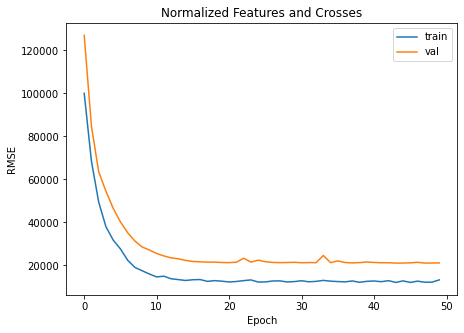

In [15]:
fig = plt.figure(figsize=(7, 5))
sns.lineplot(x=range(len(history.history['rmse'])), y=history.history['rmse'], label='train')
sns.lineplot(x=range(len(history.history['val_rmse'])), y=history.history['val_rmse'], label='val')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.title('Normalized Features and Crosses')

In [16]:
tf.saved_model.save(model, 'dnn_normalized_fc')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


2021-11-03 01:26:40.483648: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: dnn_normalized_fc/assets


In [18]:
!gsutil cp -r ./dnn_normalized_fc gs://qwiklabs-gcp-00-f6858b4e5c0c/energy_forecasting

Copying file://./dnn_normalized_fc/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://./dnn_normalized_fc/variables/variables.index [Content-Type=application/octet-stream]...
Copying file://./dnn_normalized_fc/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.


In [75]:
%%bash

saved_model_cli show --dir \
dnn_sigtest --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['day_of_year_cos_T0'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_day_of_year_cos_T0:0
  inputs['day_of_year_sin_T0'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_day_of_year_sin_T0:0
  inputs['day_pod'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_day_pod:0
  inputs['holiday_T0'] tensor_info:
      dtype: DT_STRING
      shape: (-1, 1)
      name: serving_default_holiday_T0:0
  inputs['holiday_T1'] tensor_info:
      dtype: DT_STRING
      shape: (-1, 1)
      name: serving_default_holiday_T1:0
  inputs['holiday_T10'] tensor_info:
      dtype: DT_STRING
      shape: (-1, 1)
      name: serving_default_holiday_T10:0
  inputs['holiday_T11'] tensor_info:
      dtype: DT_STRING
      shape: (-1, 1)
      name: serving_default_holiday_T11:0
  inputs['holiday_T12'] tensor_info:
      dtype: DT_STRING

2021-11-02 16:41:26.576391: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0


In [88]:
!gsutil rm -r gs://qwiklabs-gcp-00-f6858b4e5c0c/energy_forecasting/dnn_sigtest

Removing gs://qwiklabs-gcp-00-f6858b4e5c0c/energy_forecasting/dnn_sigtest/saved_model.pb#1635871524175124...
Removing gs://qwiklabs-gcp-00-f6858b4e5c0c/energy_forecasting/dnn_sigtest/variables.data-00000-of-00001#1635871531104562...
Removing gs://qwiklabs-gcp-00-f6858b4e5c0c/energy_forecasting/dnn_sigtest/variables.index#1635871524288179...
/ [3 objects]                                                                   
Operation completed over 3 objects.                                              


In [89]:
!gsutil ls gs://qwiklabs-gcp-00-f6858b4e5c0c/energy_forecasting/dnn_sigtest

CommandException: One or more URLs matched no objects.


In [90]:
!gsutil cp -r dnn_sigtest/* gs://qwiklabs-gcp-00-f6858b4e5c0c/energy_forecasting/dnn_sigtest/

Copying file://dnn_sigtest/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://dnn_sigtest/variables/variables.index [Content-Type=application/octet-stream]...
Copying file://dnn_sigtest/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

- [3 files][897.8 MiB/8

In [100]:
!gsutil ls gs://qwiklabs-gcp-00-f6858b4e5c0c/energy_forecasting/dnn_sigtest/dnn_sigtest

gs://qwiklabs-gcp-00-f6858b4e5c0c/energy_forecasting/dnn_sigtest/dnn_sigtest/saved_model.pb
gs://qwiklabs-gcp-00-f6858b4e5c0c/energy_forecasting/dnn_sigtest/dnn_sigtest/variables/


### Normalized Features and feature crosses

Text(0.5, 1.0, 'Normalized Features and Crosses')

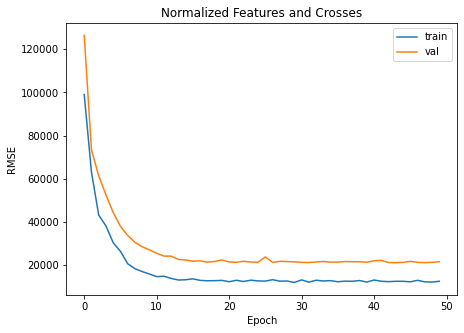

In [52]:
fig = plt.figure(figsize=(7, 5))
sns.lineplot(x=range(len(history.history['rmse'])), y=history.history['rmse'], label='train')
sns.lineplot(x=range(len(history.history['val_rmse'])), y=history.history['val_rmse'], label='val')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.title('Normalized Features and Crosses')

### Normalized Features 

Text(0.5, 1.0, 'Normalized Features')

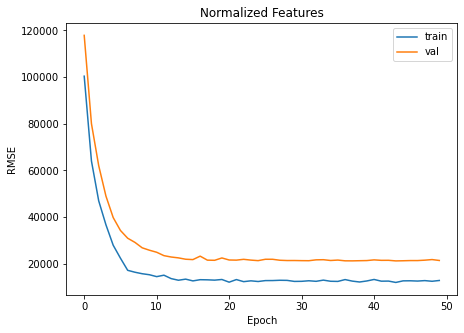

In [20]:
fig = plt.figure(figsize=(7, 5))
sns.lineplot(x=range(len(history.history['rmse'])), y=history.history['rmse'], label='train')
sns.lineplot(x=range(len(history.history['val_rmse'])), y=history.history['val_rmse'], label='val')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.title('Normalized Features')

Text(0.5, 0, 'Epoch')

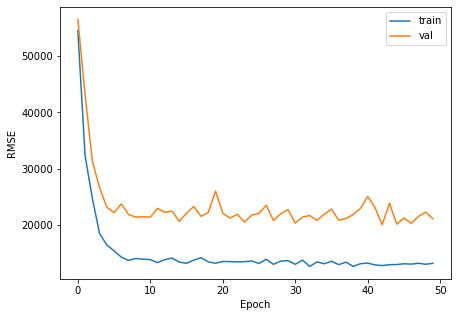

In [47]:
fig = plt.figure(figsize=(7, 5))
sns.lineplot(x=range(len(history.history['rmse'])), y=history.history['rmse'], label='train')
sns.lineplot(x=range(len(history.history['val_rmse'])), y=history.history['val_rmse'], label='val')
plt.ylabel('RMSE')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

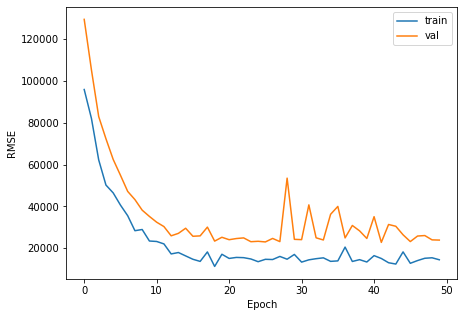

In [45]:
fig = plt.figure(figsize=(7, 5))
sns.lineplot(x=range(len(history.history['rmse'])), y=history.history['rmse'], label='train')
sns.lineplot(x=range(len(history.history['val_rmse'])), y=history.history['val_rmse'], label='val')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
#plt.title(f'Batch Size = {batch_size}, LR = {LR}, Model = {model_desc}')

In [43]:
# Approximate number of actual epochs (total interations through the the dataset)
TRAIN_BATCH_SIZE * steps_per_epoch * NUM_EVALS / train_df.shape[0]

1.8192051210624158

Text(0.5, 0, 'Epoch')

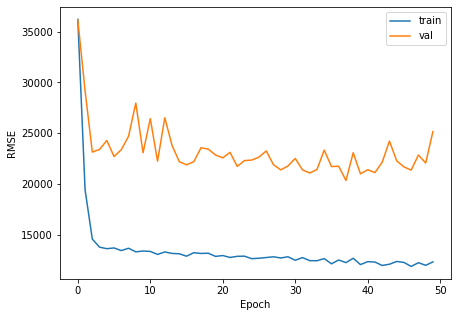

In [42]:
fig = plt.figure(figsize=(7, 5))
sns.lineplot(x=range(len(history.history['rmse'])), y=history.history['rmse'], label='train')
sns.lineplot(x=range(len(history.history['val_rmse'])), y=history.history['val_rmse'], label='val')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
#plt.title(f'Batch Size = {batch_size}, LR = {LR}, Model = {model_desc}')

### Large Model

Text(0.5, 0, 'Epoch')

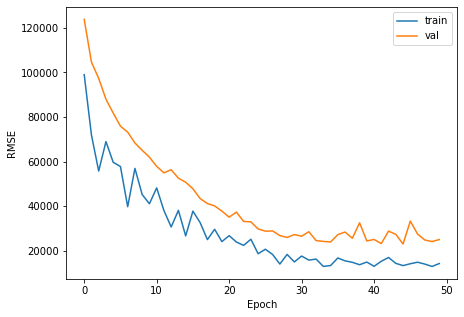

In [32]:
fig = plt.figure(figsize=(7, 5))
sns.lineplot(x=range(len(history.history['rmse'])), y=history.history['rmse'], label='train')
sns.lineplot(x=range(len(history.history['val_rmse'])), y=history.history['val_rmse'], label='val')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
#plt.title(f'Batch Size = {batch_size}, LR = {LR}, Model = {model_desc}')

In [37]:
# model.save('dnn_baseline')

INFO:tensorflow:Assets written to: dnn_baseline/assets


In [38]:
# %%bash
# gsutil cp -r dnn_baseline gs://qwiklabs-gcp-00-f6858b4e5c0c/energy_forecasting/dnn_baseline

Copying file://dnn_baseline/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://dnn_baseline/variables/variables.index [Content-Type=application/octet-stream]...
Copying file://dnn_baseline/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

- [3 files][281.0 Mi

### Medium Model

Text(0.5, 0, 'Epoch')

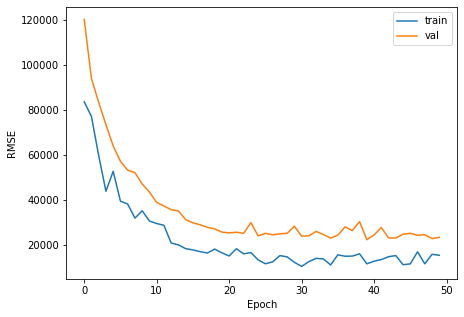

In [29]:
fig = plt.figure(figsize=(7, 5))
sns.lineplot(x=range(len(history.history['rmse'])), y=history.history['rmse'], label='train')
sns.lineplot(x=range(len(history.history['val_rmse'])), y=history.history['val_rmse'], label='val')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
#plt.title(f'Batch Size = {batch_size}, LR = {LR}, Model = {model_desc}')

In [53]:
model.predict(evalds)

array([[  230.28253,   188.55719,   223.38736, ...,   247.1169 ,
          216.3917 ,   193.95963],
       [  228.63751,   187.27342,   221.86969, ...,   245.38992,
          214.90054,   192.68205],
       [ 5172.33   ,  5003.66   ,  5149.212  , ...,  5179.037  ,
         5254.6157 ,  5153.318  ],
       ...,
       [22501.639  , 22297.36   , 22629.732  , ..., 22676.096  ,
        23012.734  , 22573.63   ],
       [ 3672.9812 ,  3517.2712 ,  3635.4568 , ...,  3666.9387 ,
         3715.1555 ,  3649.6016 ],
       [ 6002.9136 ,  5736.481  ,  5933.622  , ...,  5989.1064 ,
         6068.0713 ,  5965.3228 ]], dtype=float32)

In [58]:
tf.saved_model.save(model, 'dnn_second_model')

INFO:tensorflow:Assets written to: dnn_second_model/assets


In [60]:
loaded_model = tf.saved_model.load('dnn_second_model')

In [61]:
%%bash

saved_model_cli show --dir \
dnn_second_model --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['day_of_year_cos_T0'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_day_of_year_cos_T0:0
  inputs['day_of_year_sin_T0'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_day_of_year_sin_T0:0
  inputs['day_pod'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_day_pod:0
  inputs['holiday_T0'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_holiday_T0:0
  inputs['holiday_T1'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_holiday_T1:0
  inputs['holiday_T10'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_holiday_T10:0
  inputs['holiday_T11'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_holiday_T11:0
  inputs['holiday_T12'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
  

2021-11-02 15:59:06.369382: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0


In [56]:
loaded_model.predict(evalds)

AttributeError: '_UserObject' object has no attribute 'predict'

In [71]:
!head inputs.json

{"instances": [{"user_id": ["MT_347", "MT_003", "MT_068", "MT_265", "MT_311"], "holiday_T0": ["no holiday", "no holiday", "no holiday", "no holiday", "no holiday"], "holiday_T1": ["no holiday", "no holiday", "no holiday", "no holiday", "no holiday"], "holiday_T2": ["no holiday", "no holiday", "no holiday", "no holiday", "no holiday"], "holiday_T3": ["no holiday", "no holiday", "no holiday", "minor", "no holiday"], "holiday_T4": ["no holiday", "no holiday", "no holiday", "no holiday", "no holiday"], "holiday_T5": ["no holiday", "no holiday", "no holiday", "minor", "no holiday"], "holiday_T6": ["no holiday", "no holiday", "no holiday", "no holiday", "no holiday"], "holiday_T7": ["no holiday", "no holiday", "no holiday", "no holiday", "no holiday"], "holiday_T8": ["no holiday", "no holiday", "no holiday", "no holiday", "no holiday"], "holiday_T9": ["no holiday", "no holiday", "no holiday", "no holiday", "no holiday"], "holiday_T10": ["no holiday", "no holiday", "no holiday", "no holiday",

In [4]:
eval_df_test = eval_df.iloc[0:5,:].to_dict()

{key: list(value.values()) for key, value in eval_df_test.items()}

NameError: name 'eval_df' is not defined

In [30]:
!head inputs.json

{"instances": {"user_id": ["MT_347"], "holiday_T0": ["no holiday"], "holiday_T1": ["no holiday"], "holiday_T2": ["no holiday"], "holiday_T3": ["no holiday"], "holiday_T4": ["no holiday"], "holiday_T5": ["no holiday"], "holiday_T6": ["no holiday"], "holiday_T7": ["no holiday"], "holiday_T8": ["no holiday"], "holiday_T9": ["no holiday"], "holiday_T10": ["no holiday"], "holiday_T11": ["no holiday"], "holiday_T12": ["no holiday"], "holiday_T13": ["no holiday"], "holiday_T14": ["no holiday"], "holiday_T15": ["no holiday"], "holiday_T16": ["no holiday"], "holiday_T17": ["no holiday"], "holiday_T18": ["minor"], "holiday_T19": ["minor"], "holiday_T20": ["no holiday"], "holiday_T21": ["no holiday"], "holiday_T22": ["no holiday"], "holiday_T23": ["no holiday"], "holiday_T24": ["no holiday"], "holiday_T25": ["no holiday"], "holiday_T26": ["no holiday"], "holiday_T27": ["no holiday"], "day_pod": [0], "day_of_year_sin_T0": [-0.9937806700284983], "day_of_year_cos_T0": [0.1113551969048082], "min_temp

In [31]:
!gcloud ai endpoints predict 5536401685666070528 \
  --region=us-east1 \
  --json-request=inputs.json

Using endpoint [https://us-east1-prediction-aiplatform.googleapis.com/]
ERROR: (gcloud.ai.endpoints.predict) Invalid JSON request: "instances" must be a list


In [ ]:
total_consumption_T_minus_365
total_consumption_T_minus_365

In [118]:
import pandas as pd
eval_df = pd.read_csv('./data/validate_energy.csv')
#print(f'eval shape: {eval_df.shape}')

# column dictionary
col_dict = get_column_input_dict(eval_df)

keep_cols = col_dict['STRING_COLS'] + col_dict['NUMERIC_COLS']

eval_df_test = eval_df[keep_cols].iloc[0:2,:].to_dict()

#instances = eval_df[keep_cols].iloc[0:2, :].to_dict(orient='records')
instances = {key: list(value.values()) for key, value in eval_df_test.items()}
instances = {"instances": [instance_1, instance_2]}
instances

{'instances': [{'user_id': ['MT_347', 'MT_003'],
   'holiday_T0': ['no holiday', 'no holiday'],
   'holiday_T1': ['no holiday', 'no holiday'],
   'holiday_T2': ['no holiday', 'no holiday'],
   'holiday_T3': ['no holiday', 'no holiday'],
   'holiday_T4': ['no holiday', 'no holiday'],
   'holiday_T5': ['no holiday', 'no holiday'],
   'holiday_T6': ['no holiday', 'no holiday'],
   'holiday_T7': ['no holiday', 'no holiday'],
   'holiday_T8': ['no holiday', 'no holiday'],
   'holiday_T9': ['no holiday', 'no holiday'],
   'holiday_T10': ['no holiday', 'no holiday'],
   'holiday_T11': ['no holiday', 'no holiday'],
   'holiday_T12': ['no holiday', 'no holiday'],
   'holiday_T13': ['no holiday', 'no holiday'],
   'holiday_T14': ['no holiday', 'no holiday'],
   'holiday_T15': ['no holiday', 'no holiday'],
   'holiday_T16': ['no holiday', 'no holiday'],
   'holiday_T17': ['no holiday', 'no holiday'],
   'holiday_T18': ['minor', 'no holiday'],
   'holiday_T19': ['minor', 'no holiday'],
   'holiday

In [109]:
import json
with open('inputs.json', 'w') as json_file:
    json.dump(instances, json_file)

In [110]:
!head inputs.json

{"instances": [{"user_id": ["MT_347"], "holiday_T0": ["no holiday"], "holiday_T1": ["no holiday"], "holiday_T2": ["no holiday"], "holiday_T3": ["no holiday"], "holiday_T4": ["no holiday"], "holiday_T5": ["no holiday"], "holiday_T6": ["no holiday"], "holiday_T7": ["no holiday"], "holiday_T8": ["no holiday"], "holiday_T9": ["no holiday"], "holiday_T10": ["no holiday"], "holiday_T11": ["no holiday"], "holiday_T12": ["no holiday"], "holiday_T13": ["no holiday"], "holiday_T14": ["no holiday"], "holiday_T15": ["no holiday"], "holiday_T16": ["no holiday"], "holiday_T17": ["no holiday"], "holiday_T18": ["minor"], "holiday_T19": ["minor"], "holiday_T20": ["no holiday"], "holiday_T21": ["no holiday"], "holiday_T22": ["no holiday"], "holiday_T23": ["no holiday"], "holiday_T24": ["no holiday"], "holiday_T25": ["no holiday"], "holiday_T26": ["no holiday"], "holiday_T27": ["no holiday"], "day_pod": [0], "day_of_year_sin_T0": [-0.9937806700284983], "day_of_year_cos_T0": [0.1113551969048082], "min_tem

In [116]:
!gcloud ai endpoints predict 5536401685666070528 \
  --region=us-east1 \
  --json-request=inputs.json

Using endpoint [https://us-east1-prediction-aiplatform.googleapis.com/]
[[362.251831, 342.587097, 332.793549, 324.704773, 315.028442, 348.375, 341.841492, 319.217529, 345.203857, 351.817474, 347.712891, 334.772766, 343.713043, 322.408508, 318.454865, 317.266205, 316.505341, 331.128662, 319.910522, 337.753326, 343.042389, 314.524445, 343.461426, 327.065216, 348.721497, 320.574402, 325.542969, 323.632935], [362.251831, 342.587097, 332.793549, 324.704773, 315.028442, 348.375, 341.841492, 319.217529, 345.203857, 351.817474, 347.712891, 334.772766, 343.713043, 322.408508, 318.454865, 317.266205, 316.505341, 331.128662, 319.910522, 337.753326, 343.042389, 314.524445, 343.461426, 327.065216, 348.721497, 320.574402, 325.542969, 323.632935]]


In [125]:
model.input

{'day_pod': <tf.Tensor 'day_pod_12:0' shape=(None, 1) dtype=float32>,
 'day_of_year_sin_T0': <tf.Tensor 'day_of_year_sin_T0_12:0' shape=(None, 1) dtype=float32>,
 'day_of_year_cos_T0': <tf.Tensor 'day_of_year_cos_T0_12:0' shape=(None, 1) dtype=float32>,
 'min_temp_T0': <tf.Tensor 'min_temp_T0_12:0' shape=(None, 1) dtype=float32>,
 'min_temp_T1': <tf.Tensor 'min_temp_T1_12:0' shape=(None, 1) dtype=float32>,
 'min_temp_T2': <tf.Tensor 'min_temp_T2_12:0' shape=(None, 1) dtype=float32>,
 'min_temp_T3': <tf.Tensor 'min_temp_T3_12:0' shape=(None, 1) dtype=float32>,
 'min_temp_T4': <tf.Tensor 'min_temp_T4_12:0' shape=(None, 1) dtype=float32>,
 'min_temp_T5': <tf.Tensor 'min_temp_T5_12:0' shape=(None, 1) dtype=float32>,
 'min_temp_T6': <tf.Tensor 'min_temp_T6_12:0' shape=(None, 1) dtype=float32>,
 'min_temp_T7': <tf.Tensor 'min_temp_T7_12:0' shape=(None, 1) dtype=float32>,
 'min_temp_T8': <tf.Tensor 'min_temp_T8_12:0' shape=(None, 1) dtype=float32>,
 'min_temp_T9': <tf.Tensor 'min_temp_T9_12:0